In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import PIL.Image as Image
import torchvision
import torch.nn as nn
import torch.optim as optim
import sys

In [2]:
sys.path.insert(0, '../src')
from bird_dataset import *

In [3]:
bd = BirdDataset()

In [21]:
class XAI_Birds_Dataset(Dataset):
    
    def __init__(self, bd:BirdDataset, subset=True, transform=None, train=True):
        self.bd = bd
        self.transform = transform
        self.subset = subset
        self.train = train
        if self.train: self.train_test_indices = self.bd.train_indices
        else: self.train_test_indices = self.bd.test_indices
        
        if self.subset: self.class_dict = self._set_classes('classes-subset')
        else: self.class_dict = self._set_classes('classes')
        self.images = self.load_images()
        
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_id = list(self.images.keys())[idx]
        img_path = os.path.join(self.bd.img_dir, self.images[img_id]['filepath'])
        image = Image.open(img_path)
        label = self.class_dict[self.images[img_id]['class_label']]
        sample = {'image': image, 'label':label}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample
    def _set_classes(self, fname):
        with open(f'../CUB_200_2011/{fname}.txt') as f:
            class_dict = {int(line.split(' ')[0]):i for i, line in enumerate(f.readlines())}
        return class_dict
    
    def load_images(self):
        images = {}
        for key in self.bd.images:
            class_label = self.bd.images[key]['class_label']
            if class_label in list(self.class_dict.keys()) and class_label in self.train_test_indices:
                images[key] = self.bd.images[key] 
        return images

In [22]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_bird_dataset = XAI_Birds_Dataset(bd, transform=trans, train=True)
val_bird_dataset = XAI_Birds_Dataset(bd, transform=trans, train=False)

In [23]:
model = models.vgg16_bn(pretrained=False)
num_feats = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_feats, len(train_bird_dataset.class_dict))])
model.classifier = nn.Sequential(*features) # Replace the model classifier

In [24]:
model.load_state_dict(torch.load('../models/transfer_vgg16_31_class_5_epoch_4_batch.pth'))

<All keys matched successfully>

In [25]:
model.eval();

In [26]:
# batch_size = 4
trainloader = DataLoader(train_bird_dataset)
valloader = DataLoader(val_bird_dataset)

In [27]:


# The function to show an image.
def imshow(img):
#     img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



In [28]:
# dataiter.next()

In [29]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [30]:
if torch.cuda.is_available():
    model.cuda()

In [31]:
class_dict = val_bird_dataset.class_dict

In [32]:
inv_classes = {v: k for k, v in class_dict.items()}

In [33]:
# labels

In [34]:
def topk_accuracy(k, labels, outputs):
    num_correct = 0
    _, predicted = outputs.topk(5, -1, largest=True, sorted=True)
    for idx, pred in enumerate(predicted):
#         print(labels[idx])
#         print(pred)
        if int(labels[idx]) in np.array(pred.cpu()): 
            num_correct += 1
    return num_correct

In [35]:
%%time
num_correct = 0
num_correct_k = 0
k = 5
# Check several images.
dataiter = iter(valloader)
batch_size = 1
for i in range(len(dataiter)):
    sample = dataiter.next()
    images, labels = sample['image'], sample['label']    
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)
    #     print(predicted)
    # print(labels)
    # print(predicted)
    num_correct_k += topk_accuracy(k, labels, outputs)
    num_correct += sum(np.array(labels)==np.array(predicted.cpu()))
    if i % 200 == 0:
        print("iteration",i)

iteration 0
iteration 200
CPU times: user 14.3 s, sys: 210 ms, total: 14.5 s
Wall time: 2.95 s


In [20]:
len(trainloader)

1596

In [36]:
print("Accuracy:", num_correct / (len(valloader) * batch_size))
print(f"Top {k} Accuracy:", num_correct_k / (len(valloader) * batch_size))

Accuracy: 0.9533898305084746
Top 5 Accuracy: 0.9957627118644068


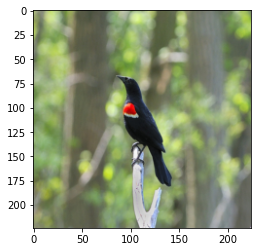

Ground Truth: [10]
Predicted: [10]
Accuracy: 1.0


In [37]:
# Check several images.
dataiter = iter(valloader)
batch_size = 1
# for i in range(len(dataiter)):
sample = dataiter.next()
images, labels = sample['image'], sample['label']
imshow(torchvision.utils.make_grid(images))
# print(labels)
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print("Ground Truth:", [inv_classes[int(labels[i])] for i in range(batch_size)])
print("Predicted:",[inv_classes[int(predicted[i])] for i in range(batch_size)])
print("Accuracy:",sum(np.array(labels)==np.array(predicted.cpu()))/len(labels))

In [39]:
!pip install captum

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 4.4 MB 18.7 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [40]:
from captum.attr import GuidedGradCam

{'image': tensor([[[[0.6392, 0.6510, 0.6471,  ..., 0.4863, 0.4627, 0.4431],
           [0.6431, 0.6627, 0.6588,  ..., 0.5176, 0.4902, 0.4588],
           [0.6471, 0.6627, 0.6510,  ..., 0.5333, 0.5020, 0.4745],
           ...,
           [0.5373, 0.5412, 0.5451,  ..., 0.4157, 0.4275, 0.4392],
           [0.5569, 0.5490, 0.5490,  ..., 0.4157, 0.4353, 0.4549],
           [0.5725, 0.5569, 0.5412,  ..., 0.4157, 0.4314, 0.6471]],
 
          [[0.7137, 0.7176, 0.6941,  ..., 0.5725, 0.5333, 0.5020],
           [0.7216, 0.7255, 0.6980,  ..., 0.6118, 0.5686, 0.5255],
           [0.7137, 0.7137, 0.6902,  ..., 0.6431, 0.5922, 0.5490],
           ...,
           [0.5725, 0.5686, 0.5608,  ..., 0.4196, 0.4275, 0.4353],
           [0.5922, 0.5765, 0.5608,  ..., 0.4157, 0.4235, 0.4353],
           [0.6000, 0.5804, 0.5608,  ..., 0.4157, 0.4157, 0.6275]],
 
          [[0.4588, 0.4824, 0.4863,  ..., 0.3882, 0.3882, 0.3765],
           [0.4471, 0.4784, 0.4941,  ..., 0.3961, 0.3961, 0.3804],
           [0.4

In [58]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [59]:
last_conv = model.features[40]
gc = GuidedGradCam(model, last_conv)
samp = iter(valloader).next()
img, label = samp['image'].cuda(), samp['label'].cuda()
# img, label =  val_bird_dataset[0]['image'], val_bird_dataset[0]['label']
# for feat in model.features[:40]:
#     img = feat(img)

In [63]:
gc_img = gc.attribute(img, label)

In [86]:
import cv2
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz

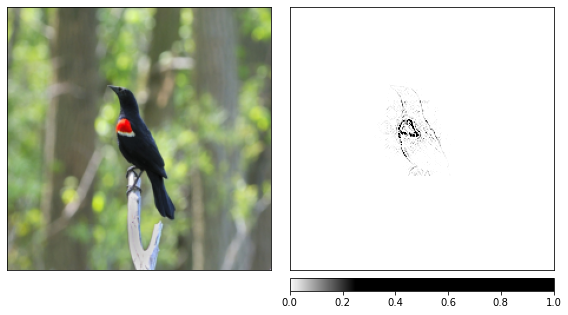

In [87]:
# create custom colormap for visualizing the result
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


# visualize the results using the visualize_image_attr helper method
_ = viz.visualize_image_attr_multiple(np.transpose(gc_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)

In [ ]:
# show some more examples...

In [85]:
sum(gc_img.cpu().detach().numpy()[0][0])

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


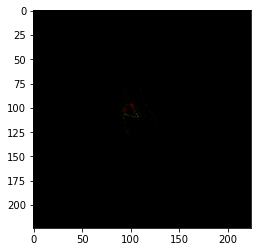

In [66]:
imshow(torchvision.utils.make_grid(gc_img.cpu().detach()))


In [53]:
gc?

In [57]:
last_conv

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [56]:
img.size()

torch.Size([1, 512, 14, 14])